In this notebook I look at the most popular categories of Google Play apps in Spain vs US.

I use the [Google Play Top Charts API](https://42matters.com/api/top-google-charts) to retrieve some data from Play.

In [21]:
from collections import Counter
from configparser import ConfigParser
import csv
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pprint import pprint as pp
import requests
%matplotlib inline

If you want to run this analysis yourself (maybe you want to check other countries), get a 42 matters API key and define a config file called notebook.conf in the same directory as this notebook, with the following values

    [vars]
    apikey = <your_api_key>
    country = <your_primary_country> -> I use ES (Spain)
    compare_country = <your_compareTo_country> -> I use US (United States)
    limit = <how_many_top_results> -> I use 20

In [2]:
list_names = ( "topselling_free", "topselling_paid", "movers_shakers", 
              "topgrossing", "topselling_new_free", "topselling_new_paid" )

In [3]:
config = ConfigParser()
config.read("notebook.conf")

['notebook.conf']

In [4]:
access_token = config["vars"]["apikey"]
country = config["vars"]["country"]
compare_country = config["vars"]["compare_country"]
limit = config["vars"]["limit"]

In [5]:
def get_request_url(*args):
    return "https://data.42matters.com/api/v2.0/android/apps/top_google_charts.json?" +\
        "list_name={}&cat_key=OVERALL&country={}&limit={}&access_token={}".format(*args)

In [6]:
def get_top_categories_from_response(resp):
    cats = [app["category"] for app in resp["app_list"]]
    cats_count = Counter(cats)
    return dict(cats_count.most_common(5))

In [7]:
# cache data for drill down if necessary (save API calls!)
cache = {
    country: {},
    compare_country: {},
}

In [8]:
trends = {
    country: {},
    compare_country: {},
}

In [9]:
# reduce list_names if you want to save API calls, free 42 matters account gives you 1000 hits
# each call = 3 hits, so 2 countries x 6 lists x 3 hits = 36 hits
def get_stats(country):
    for lname in list_names:
        url = get_request_url(lname, country, limit, access_token)
        resp = requests.get(url).json()
        cache[country][lname] = resp
        trends[country][lname] = get_top_categories_from_response(resp)

In [10]:
for co in (country, compare_country):
    get_stats(co)

In [79]:
# verify response
pp(trends["ES"]["topselling_new_free"])

{'Action': 2, 'Casual': 6, 'Role Playing': 4, 'Simulation': 2, 'Sports': 1}


In [82]:
# cache is like this:
pp(cache["US"]["topgrossing"])

{'app_list': [{'badges': ['Top Developer'],
               'cat_int': 42,
               'cat_key': 'GAME_STRATEGY',
               'cat_keys': ['GAME_STRATEGY', 'GAME'],
               'cat_type': 1,
               'category': 'Strategy',
               'content_rating': 'Everyone 10+',
               'created': '2014-03-12T00:00:00+00:00',
               'deep_link': 'http://playboard.me/android/apps/com.machinezone.gow',
               'description': 'Don’t miss your chance to become legendary! '
                              'Lead massive armies into epic battles against '
                              'dragons, monsters, and players from around the '
                              'globe in the most addicting, interactive '
                              'strategy game! Are you ready for an '
                              'action-packed adventure?\n'
                              '\n'
                              'FEATURES\n'
                              '✔ Build & customize your 

In [222]:
# dump cache to a file
for co in (country, compare_country):
    writer = csv.writer(open('cache_%s.csv' % co, 'w'))
    for key, value in cache[co].items():
        for app in value["app_list"]:
            writer.writerow(app.values())

In [18]:
df1 = pd.DataFrame(trends[country]); df1.head(3)

,movers_shakers,topgrossing,topselling_free,topselling_new_free,topselling_new_paid,topselling_paid
Action,3.0,2.0,2.0,2.0,3.0,NaN
Adventure,NaN,NaN,NaN,NaN,3.0,NaN
Arcade,1.0,NaN,NaN,NaN,NaN,2.0


In [19]:
df2 = pd.DataFrame(trends[compare_country]); df2.head(3)

,movers_shakers,topgrossing,topselling_free,topselling_new_free,topselling_new_paid,topselling_paid
Action,2.0,2.0,NaN,NaN,2.0,NaN
Adventure,2.0,NaN,NaN,NaN,3.0,2.0
Arcade,NaN,NaN,NaN,NaN,NaN,2.0


## Spanish Android app market:

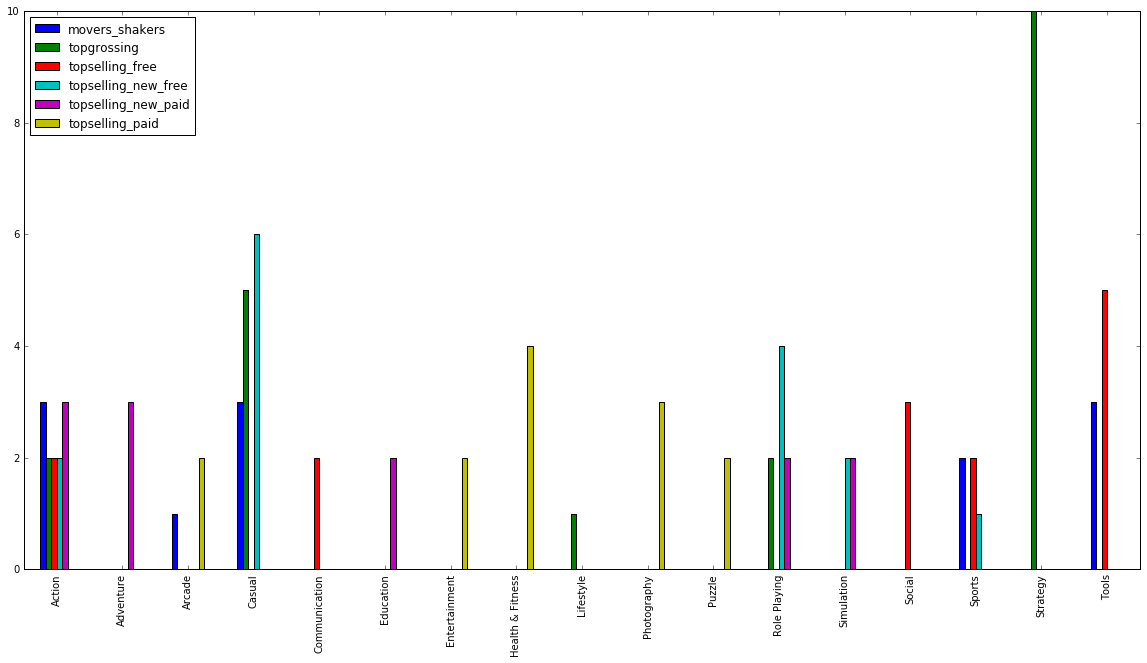

In [37]:
plt1 = df1.plot(kind="bar")
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(20, 10)

## US Android app market:

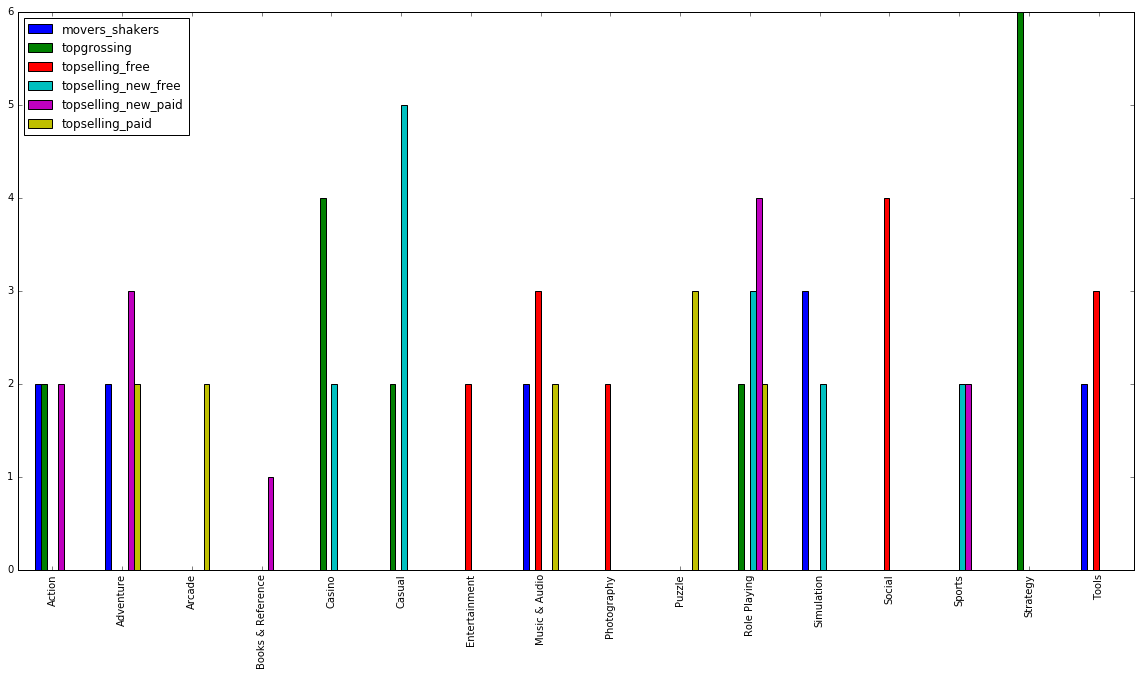

In [36]:
plt2 = df2.plot(kind="bar")
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(20, 10)

Interesting: 

* Strategy is a highly topgrossing on both markets
* Casino is topgrossing in US, but not in Spain, weird as Spanish like lottery and stuff
* There are apps that are doing good as free vs paid. Social for example is topselling Free, Puzzel is topselling Paid
* Some apps are doing well as Paid in Spain but Free in US (Entertainment) 
* In both markets tools are topselling free as well as trending

So what are strategy apps, what social apps are popular, what is casual? Etc ... Let's do some inspection in the cached data ...

### Top categories in Spain but not in US

In [209]:
idx1 = pd.Index(df1.index)
idx2 = pd.Index(df2.index)
es_unique_cats = idx1.difference(idx2); es_unique_cats

Index(['Communication', 'Education', 'Health & Fitness', 'Lifestyle'], dtype='object')

### Top categories in US but not in Spain

In [208]:
idx3 = pd.Index(df2.index)
idx4 = pd.Index(df1.index)
us_unique_cats = idx3.difference(idx4); us_unique_cats

Index(['Books & Reference', 'Casino', 'Music & Audio'], dtype='object')

### Which apps are uniquely popular in each country?

Some helpers:

In [185]:
def get_apps(country, category):
    apps = []
    for lname, details in cache[country].items():
        for app in details["app_list"]:
            if app["category"].lower() != category.lower():
                continue
            apps.append(app["title"])
    return apps

In [195]:
def inspect(country, compare_country, category):
    apps_co1 = get_apps(country, category)
    apps_co2 = get_apps(compare_country, category)
    return list(set(apps_co1) - set(apps_co2))

Note that the following comparison is based on the top 20 of each list. So YouTube Music is surely in Spain's Play store, but it is not in the top 20 it seems.

### Top 20 categories unique to Spain (as compared to US)

In [217]:
for cat in es_unique_cats:
    print("\n" + cat)
    for app in inspect("ES", "US", cat):
        print("- " + app)


Communication
- Heartbits

Education
- FCE Academy

Health & Fitness
- Runtastic PRO Running, Fitness
- My Diet Coach - Pro
- White Noise
- 7 Minute Workout Pro

Lifestyle
- Páginas Amarillas España
- Ser de Orange
- Sleep as Android Unlock
- McDonald's España
- Tinder


### Top 20 categories unique to US (as compared to Spain)

In [223]:
for cat in us_unique_cats:
    print("\n" + cat)
    for app in inspect("US", "ES", cat):
        print("- " + app)


Books & Reference
- The EO Bar

Casino
- MONOPOLY Bingo!: World Edition
- Slotomania - Free Slots Casino
- Slots-House of Fun-Free Casino
- Heart of Vegas™ Slots Casino
- SLOTS: GET RICH Free Slot Game
- Big Fish Casino – Free Slots

Music & Audio
- Music Paradise Pro
- YouTube Music
- Pandora® Radio
- Ultimate Guitar Tabs & Chords
